# **Deep Convolutional Wasserstein GAN**

## **Libraries**

In [1]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
random_seed = 0
generator_learning_rate = 0.00005
discriminator_learning_rate = 0.00005
NUM_EPOCHS = 10
BATCH_SIZE = 128
LATENT_DIM = 100
IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

In [5]:
num_iter_critic = 5
weight_clip_value = 0.01

## **MNIST dataset**

In [6]:
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

In [7]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [8]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)


def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)

In [10]:
class GAN(torch.nn.Module):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = nn.Sequential(
              
            nn.Linear(LATENT_DIM, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape1(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            nn.Conv2d(in_channels=8, out_channels=16, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            nn.Conv2d(in_channels=16, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            Flatten(),

            nn.Linear(512, 1),
        )
            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [11]:
torch.manual_seed(random_seed)

In [12]:
model = GAN()
model = model.to(device)

In [13]:
print(model)

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape1()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 

In [14]:
optim_gener = torch.optim.RMSprop(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.RMSprop(model.discriminator.parameters(), lr=discriminator_learning_rate)

## **Training phase**

In [15]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(NUM_EPOCHS):
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 

        targets = targets.to(device)

        valid = -(torch.ones(targets.size(0)).float()).to(device)
        fake = torch.ones(targets.size(0)).float().to(device)
        
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(0.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        discr_pred = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28))
        
        gener_loss = wasserstein_loss(valid, discr_pred)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        for _ in range(num_iter_critic):
        
            discr_pred_real = model.discriminator_forward(features.view(targets.size(0), 1, 28, 28))
            real_loss = wasserstein_loss(valid, discr_pred_real)

            discr_pred_fake = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28).detach())
            fake_loss = wasserstein_loss(fake, discr_pred_fake)

            discr_loss = 0.5*(real_loss + fake_loss)
            
            optim_discr.zero_grad()
            discr_loss.backward()
            optim_discr.step()        

            for p in model.discriminator.parameters():
                p.data.clamp_(-weight_clip_value, weight_clip_value)

        
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        if not batch_idx % 100:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), gener_loss, discr_loss))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 000/469 | Gen/Dis Loss: 0.3224/-0.0001
Epoch: 001/010 | Batch 100/469 | Gen/Dis Loss: 0.0034/-0.0025
Epoch: 001/010 | Batch 200/469 | Gen/Dis Loss: 0.0106/-0.0119
Epoch: 001/010 | Batch 300/469 | Gen/Dis Loss: 0.0115/-0.0120
Epoch: 001/010 | Batch 400/469 | Gen/Dis Loss: 0.0136/-0.0133
Time elapsed: 1.99 min
Epoch: 002/010 | Batch 000/469 | Gen/Dis Loss: 0.0144/-0.0131
Epoch: 002/010 | Batch 100/469 | Gen/Dis Loss: 0.0129/-0.0127
Epoch: 002/010 | Batch 200/469 | Gen/Dis Loss: 0.0126/-0.0112
Epoch: 002/010 | Batch 300/469 | Gen/Dis Loss: 0.0110/-0.0103
Epoch: 002/010 | Batch 400/469 | Gen/Dis Loss: 0.0124/-0.0097
Time elapsed: 3.96 min
Epoch: 003/010 | Batch 000/469 | Gen/Dis Loss: 0.0114/-0.0108
Epoch: 003/010 | Batch 100/469 | Gen/Dis Loss: 0.0101/-0.0103
Epoch: 003/010 | Batch 200/469 | Gen/Dis Loss: 0.0089/-0.0089
Epoch: 003/010 | Batch 300/469 | Gen/Dis Loss: 0.0083/-0.0092
Epoch: 003/010 | Batch 400/469 | Gen/Dis Loss: 0.0062/-0.0086
Time elapsed: 5.95 min
E

In [16]:
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Total Training Time: 19.79 min


## **Evaluation**

/tmp/ipykernel_8598/564946603.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(newlabel[::10])


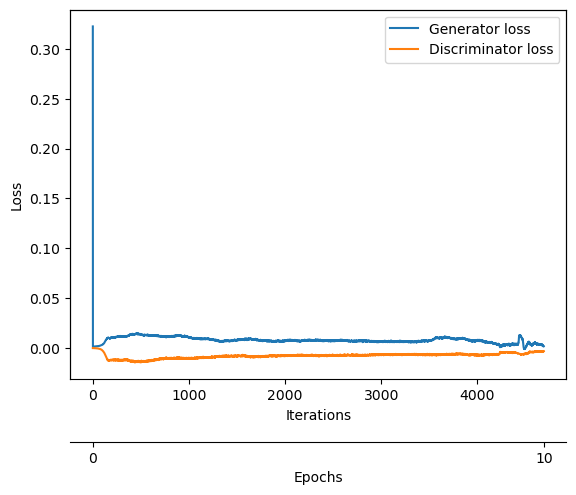

In [17]:
ax1 = plt.subplot(1, 1, 1)
ax1.plot(range(len(gener_costs)), gener_costs, label='Generator loss')
ax1.plot(range(len(discr_costs)), discr_costs, label='Discriminator loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = ax1.twiny()
newlabel = list(range(NUM_EPOCHS+1))
iter_per_epoch = len(train_loader)
newpos = [e*iter_per_epoch for e in newlabel]

ax2.set_xticklabels(newlabel[::10])
ax2.set_xticks(newpos[::10])

ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 45))
ax2.set_xlabel('Epochs')
ax2.set_xlim(ax1.get_xlim())

plt.show()

In [18]:
model.eval()

GAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape1()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 

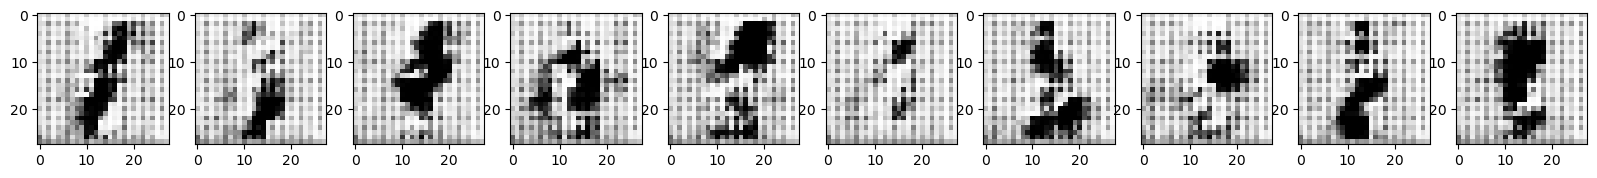

In [19]:
z = torch.zeros((10, LATENT_DIM)).uniform_(0.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 2.5))

for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')